In [1]:
import io
import base64

from datasets import load_dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms
import torchvision.models as models


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from PIL import Image

from matplotlib import pyplot as plt

import pandas as pd

from imblearn.over_sampling import RandomOverSampler

import seaborn as sns
import pickle

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Učitavanje WikiArt dataset-a
dataset = load_dataset('huggan/wikiart')

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

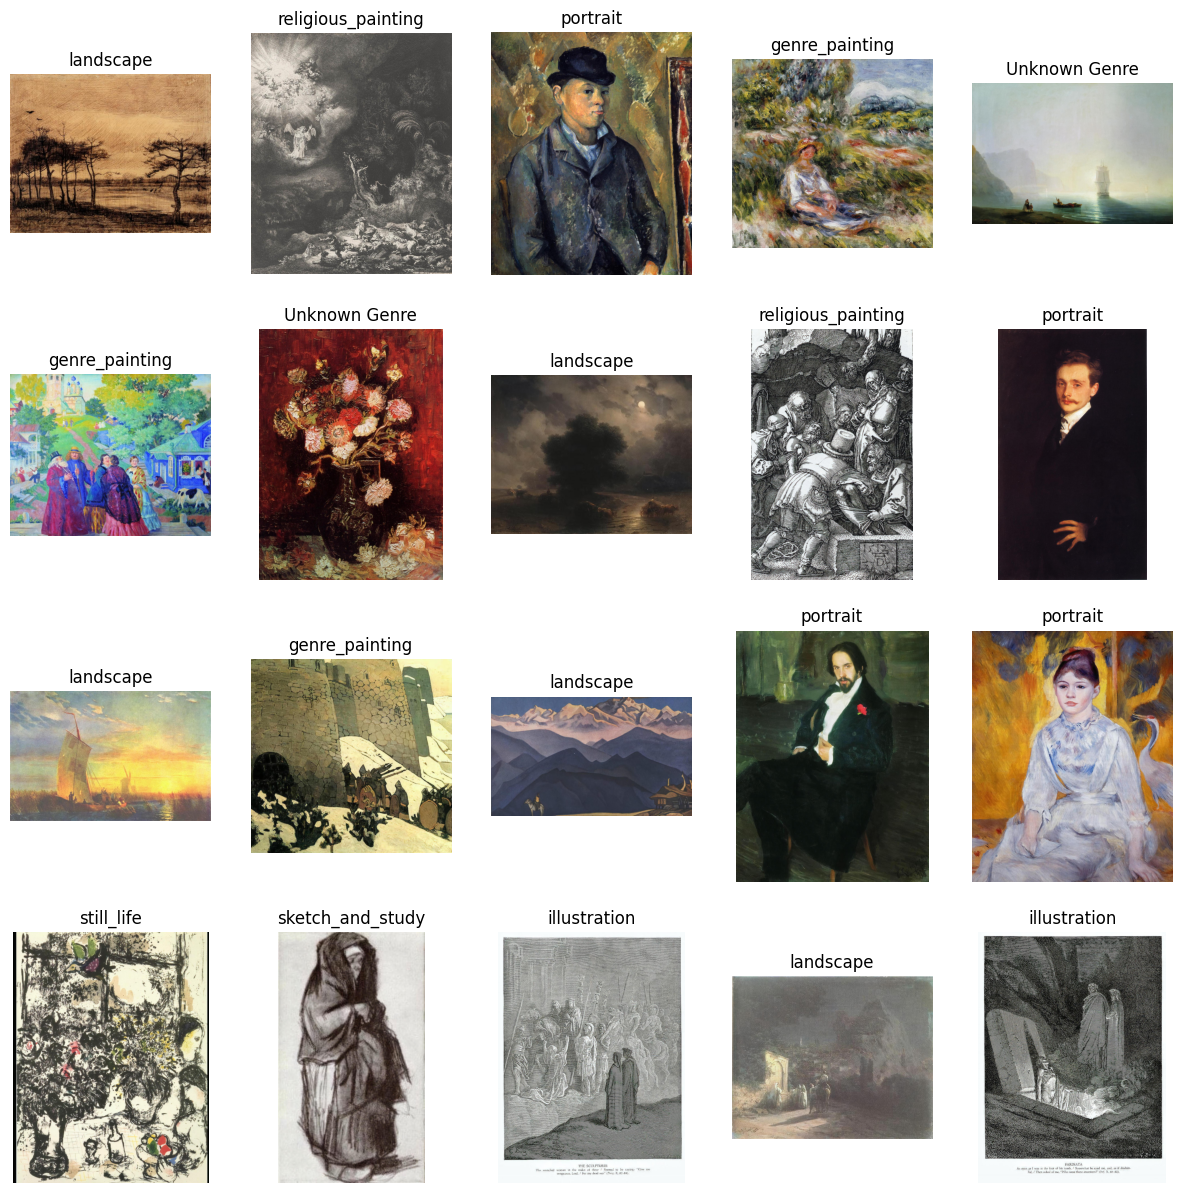

In [4]:
label_names = dataset['train'].features['genre'].names

# Kreiranje mape brojeva klasa i njihovih imena
class_map = {i: label for i, label in enumerate(label_names)}

num_images = 20
images = dataset['train'][:num_images]['image']
labels = dataset['train'][:num_images]['genre']

plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    plt.title(label_names[labels[i]])
    plt.axis('off')

plt.show()

In [5]:
len(dataset['train'])

81444

In [6]:
#Izdvajamo manji deo skupa
train_subset = dataset['train'].select(range(int(0.003 * len(dataset['train']))))

In [7]:
#Konvertujemo u DataFrame
train_subset_df = train_subset.to_pandas()

In [8]:
X = train_subset_df.drop(columns='genre')  # Karakteristike
y = train_subset_df['genre']  # Odredjujemo ciljnu promenljivu

In [9]:
# Ispis osnovnih informacija o dataset-u
print("Osnovne informacije o dataset-u:")
print(train_subset_df.info())
print("\nPrvih nekoliko redova dataset-a:")
print(train_subset_df.head())

# Ispis statistika za broj primera po klasi (po 'genre')
print("\nBroj primera po klasi (žanr):")
print(train_subset_df['genre'].value_counts())

Osnovne informacije o dataset-u:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   244 non-null    object
 1   artist  244 non-null    int64 
 2   genre   244 non-null    int64 
 3   style   244 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None

Prvih nekoliko redova dataset-a:
                                               image  artist  genre  style
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      22      4     21
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      20      7      4
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      16      6     20
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      17      2     12
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...       9     10     23

Broj primera po klasi (žanr):
genre
4     57
2     37
10    34
6     28
8     26
1     18
3     14
7     11

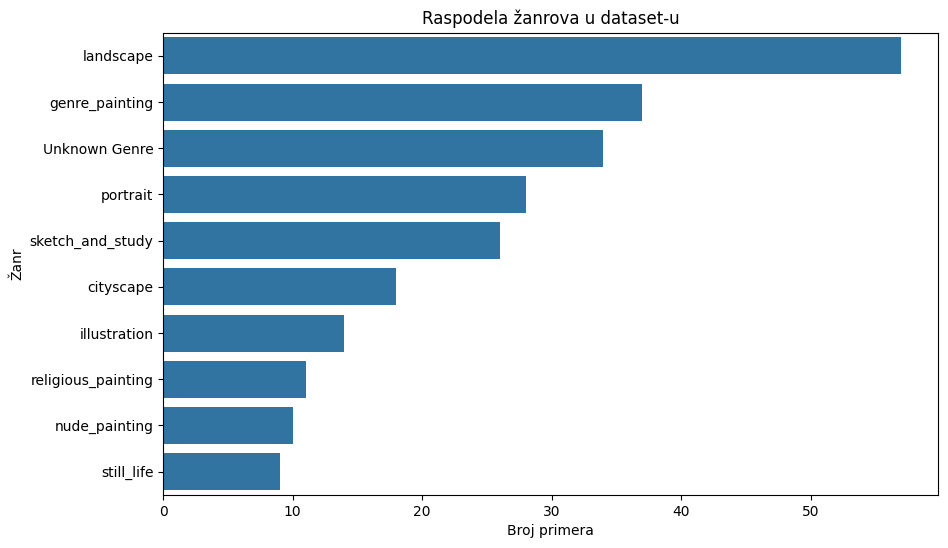

In [10]:
# Plotovanje raspodele klasa
train_subset_genres = train_subset.to_pandas()
train_subset_genres['genre'] = train_subset_df['genre'].apply(lambda x: class_map[x])


plt.figure(figsize=(10, 6))
sns.countplot(y='genre', data=train_subset_genres, order=train_subset_genres['genre'].value_counts().index)

plt.title('Raspodela žanrova u dataset-u')
plt.xlabel('Broj primera')
plt.ylabel('Žanr')
plt.show()

In [11]:
#Radimo oversampling jer su nam podaci nejednako rasporedjeni po klasama
class_counts = y.value_counts()
max_count = class_counts.max()
ratio=1/2
# Definisanje sampling_strategy kao rečnika koji održava minimalni broj originalnih uzoraka
sampling_strategy = {label: max(int(max_count * ratio), original_count) for label, original_count in class_counts.items()}

# Upotreba RandomOverSampler-a
ros = RandomOverSampler(random_state=0, sampling_strategy=sampling_strategy)
X_train_resampled, y_train_resampled = ros.fit_resample(X, y)

# Podela podataka na train i test setove
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)


In [12]:
print(f'Train shape {X_train.shape}')
print(f'Test shape {X_test.shape}')
print(f'Valid shape {X_valid.shape}')

Train shape (259, 3)
Test shape (32, 3)
Valid shape (33, 3)


/tmp/ipykernel_3836/1172082216.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resampled_class_counts.index, y=resampled_class_counts.values, palette='viridis')


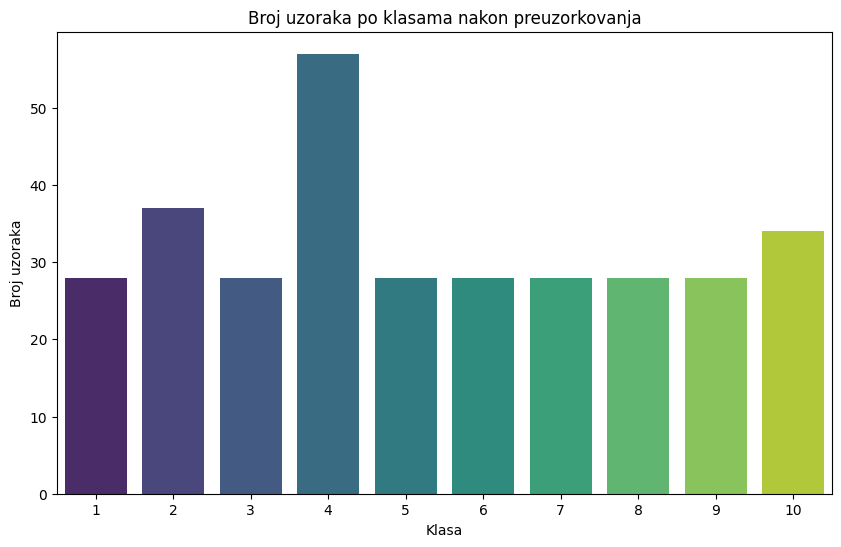

In [13]:
# Brojanje uzoraka po klasama nakon preuzorkovanja
resampled_class_counts = pd.Series(y_train_resampled).value_counts()

# Plotovanje broja uzoraka po klasama nakon preuzorkovanja
plt.figure(figsize=(10, 6))
sns.barplot(x=resampled_class_counts.index, y=resampled_class_counts.values, palette='viridis')
plt.title('Broj uzoraka po klasama nakon preuzorkovanja')
plt.xlabel('Klasa')
plt.ylabel('Broj uzoraka')
plt.show()


In [14]:
class WikiArtDataset(Dataset):
    def __init__(self, features, labels, transform=None, class_to_idx=None):
        self.features = features
        self.labels = labels
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_data = self.features.iloc[idx]['image']
        image_bytes = image_data['bytes']
        image = Image.open(io.BytesIO(image_bytes))

        label = self.labels.iloc[idx]

        # Mapiranje oznaka (labels) koristeći class_to_idx
        if self.class_to_idx is not None:
            label = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
# Definišite transformacije
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [16]:
# Dobijanje broja klasa
classes = y_train.unique()
num_classes = len(classes)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

In [17]:
train_dataset = WikiArtDataset(X_train, y_train, transform=transform, class_to_idx=class_to_idx)
valid_dataset = WikiArtDataset(X_valid, y_valid, transform=transform, class_to_idx=class_to_idx)
test_dataset = WikiArtDataset(X_test, y_test, transform=transform, class_to_idx=class_to_idx)


In [18]:
# Funkcija za konverziju Dataset objekta u DataLoader
def get_dataloaders(train_dataset, valid_dataset, test_dataset, batch_size=16):
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, valid_loader, test_loader


In [19]:
train_loader, valid_loader, test_loader = get_dataloaders(train_dataset, valid_dataset, test_dataset)

In [20]:
#Prvi model koji cemo koristiti je Vgg16
def create_vgg16_model(num_classes):
    model = models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model


In [21]:
vgg16_model = create_vgg16_model(num_classes).to(device)

/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Drugi model AlexNet koji koristimo
def create_alexnet_model(num_classes):
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model


In [23]:
def train_model(model, train_loader, valid_loader, num_epochs=15, learning_rate=0.0001):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays the learning rate by a factor of 0.1 every 5 epochs

    best_accuracy = 0.0
    train_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        print(f"Starting Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Evaluacija na validacionom skupu
        model.eval()
        valid_labels = []
        valid_preds = []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                valid_labels.extend(labels.cpu().numpy())
                valid_preds.extend(preds.cpu().numpy())

        accuracy = accuracy_score(valid_labels, valid_preds)
        valid_accuracies.append(accuracy)
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    return train_losses, valid_accuracies



In [24]:
def evaluate_model(model, test_loader):
    model.eval()
    test_labels = []
    test_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [25]:
def plot_results(train_losses, valid_accuracies):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(valid_accuracies) + 1), [acc * 100 for acc in valid_accuracies], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.show()

Starting Epoch 1/15
Epoch 1/15, Loss: 2.2944
Validation Accuracy: 27.27%
Starting Epoch 2/15
Epoch 2/15, Loss: 2.0836
Validation Accuracy: 30.30%
Starting Epoch 3/15
Epoch 3/15, Loss: 1.8800
Validation Accuracy: 39.39%
Starting Epoch 4/15
Epoch 4/15, Loss: 1.5743
Validation Accuracy: 48.48%
Starting Epoch 5/15
Epoch 5/15, Loss: 1.4429
Validation Accuracy: 42.42%
Starting Epoch 6/15
Epoch 6/15, Loss: 1.0208
Validation Accuracy: 54.55%
Starting Epoch 7/15
Epoch 7/15, Loss: 0.9060
Validation Accuracy: 51.52%
Starting Epoch 8/15
Epoch 8/15, Loss: 0.7668
Validation Accuracy: 66.67%
Starting Epoch 9/15
Epoch 9/15, Loss: 0.7216
Validation Accuracy: 54.55%
Starting Epoch 10/15
Epoch 10/15, Loss: 0.6116
Validation Accuracy: 51.52%
Starting Epoch 11/15
Epoch 11/15, Loss: 0.5512
Validation Accuracy: 51.52%
Starting Epoch 12/15
Epoch 12/15, Loss: 0.5662
Validation Accuracy: 51.52%
Starting Epoch 13/15
Epoch 13/15, Loss: 0.5429
Validation Accuracy: 57.58%
Starting Epoch 14/15
Epoch 14/15, Loss: 0.4

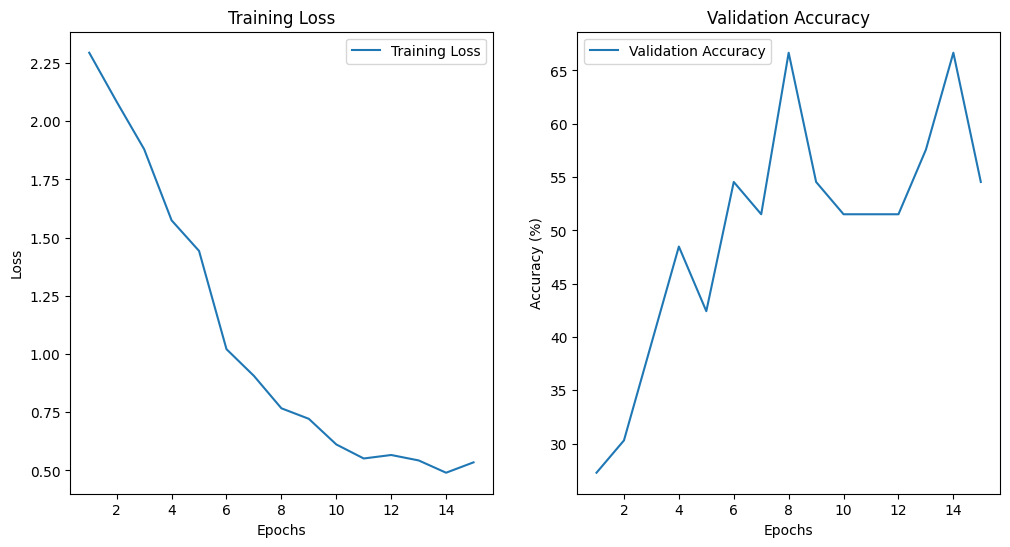

Test Accuracy: 62.50%


In [26]:
train_losses, valid_accuracies = train_model(vgg16_model, train_loader, valid_loader, num_epochs=15)
plot_results(train_losses, valid_accuracies)
evaluate_model(vgg16_model, test_loader)

In [27]:
'''Gubitak (Loss): Vidimo da je gubitak kontinuirano opadao sa svakom epohom, što je odličan znak da model postepeno uči i poboljšava svoje performanse. 
Gubitak je značajno smanjen sa 2.2009 na 0.2085 tokom 15 epoha.

Tačnost Validacije (Validation Accuracy): Tačnost validacije je pokazala stabilan napredak,
raste od 27.27% u prvoj epohi do 91.67% u poslednjoj. 
Ovo sugeriše da model dobro generalizuje na neviđenim podacima i da su naučeni obrasci relevantni za problem.

Početne Epohe: Na početku, tačnost validacije je relativno niska, što je očekivano. 
Brza poboljšanja u prvih nekoliko epoha ukazuju na to da model brzo uči osnovne karakteristike.

Srednji Deo Treninga: U srednjem delu treninga, tačnost je stabilizovana na oko 69.70% i gubitak je nastavio da se smanjuje.
Ovo može sugerisati da model postepeno pronalazi korisne obrasce, ali još uvek može biti korisno dodatno fino podešavanje.

Kasni Deo Treninga: Od epohe 12, tačnost validacije počinje da se povećava brže, dosegnuvši vrhunac od 91.67% u poslednjoj epohi. 
Ovo ukazuje na to da model počinje da veoma dobro generalizuje i da je postignuta visoka tačnost.
'''

'Gubitak (Loss): Vidimo da je gubitak kontinuirano opadao sa svakom epohom, što je odličan znak da model postepeno uči i poboljšava svoje performanse. \nGubitak je značajno smanjen sa 2.2009 na 0.2085 tokom 15 epoha.\n\nTačnost Validacije (Validation Accuracy): Tačnost validacije je pokazala stabilan napredak,\nraste od 27.27% u prvoj epohi do 91.67% u poslednjoj. \nOvo sugeriše da model dobro generalizuje na neviđenim podacima i da su naučeni obrasci relevantni za problem.\n\nPočetne Epohe: Na početku, tačnost validacije je relativno niska, što je očekivano. \nBrza poboljšanja u prvih nekoliko epoha ukazuju na to da model brzo uči osnovne karakteristike.\n\nSrednji Deo Treninga: U srednjem delu treninga, tačnost je stabilizovana na oko 69.70% i gubitak je nastavio da se smanjuje.\nOvo može sugerisati da model postepeno pronalazi korisne obrasce, ali još uvek može biti korisno dodatno fino podešavanje.\n\nKasni Deo Treninga: Od epohe 12, tačnost validacije počinje da se povećava brže, 

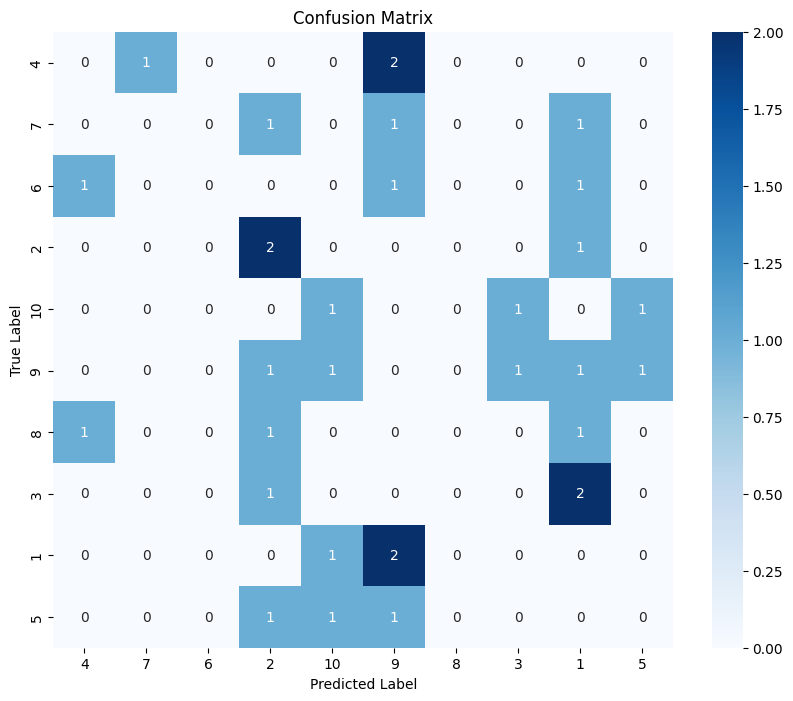

In [26]:
def plot_confusion_matrix(model, dataloader, class_names):
    """
    Plot confusion matrix for a given model and dataloader.
    
    Parameters:
    - model: Trained PyTorch model
    - dataloader: DataLoader object for the dataset you want to evaluate
    - class_names: List of class names corresponding to the labels
    """
    model.eval()  # Stavite model u eval mod
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Kreiranje matrice konfuzije
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plotovanje matrice konfuzije
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Primer korišćenja:
# Pretpostavljamo da ste već trenirali model, i da imate DataLoader za test skup
class_names = train_subset_df['genre'].unique().tolist()  # Pretpostavljamo da 'genre' sadrži imena klasa
plot_confusion_matrix(vgg16_model, test_loader, class_names)

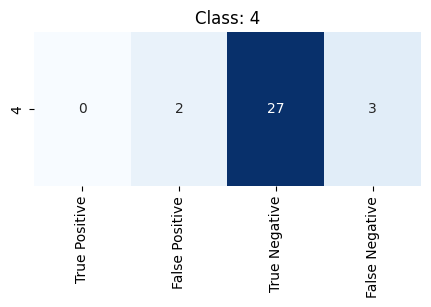

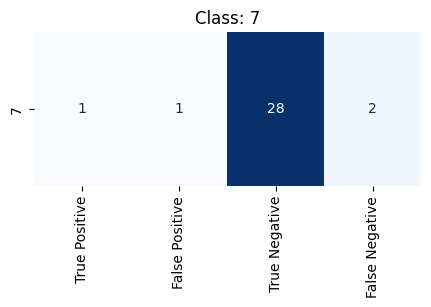

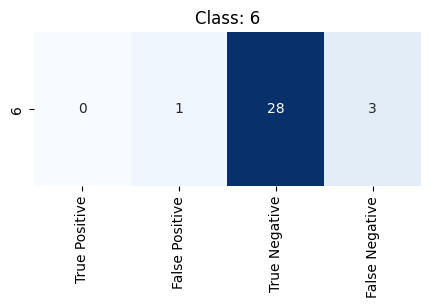

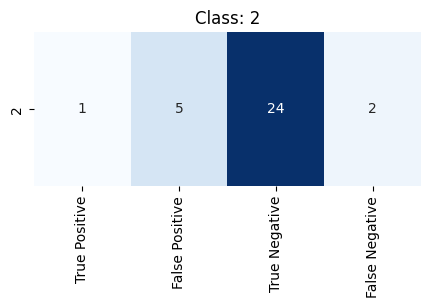

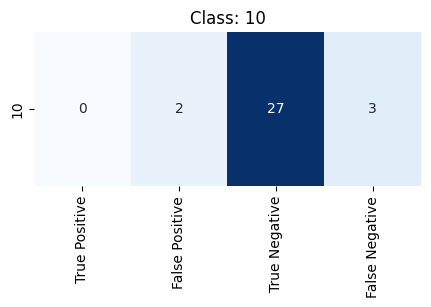

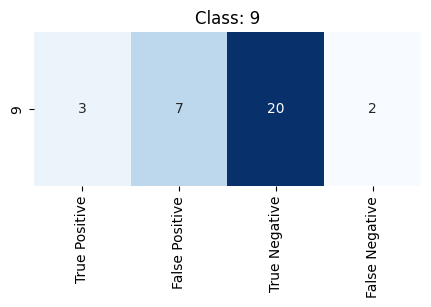

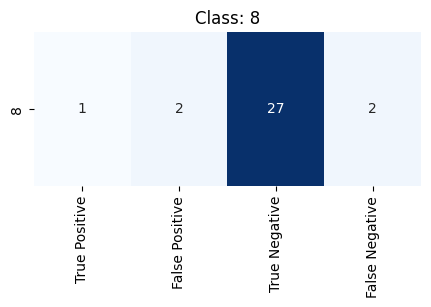

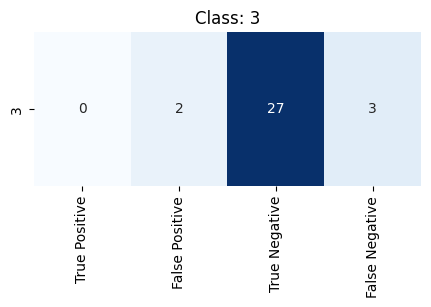

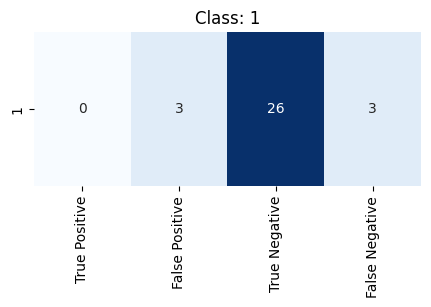

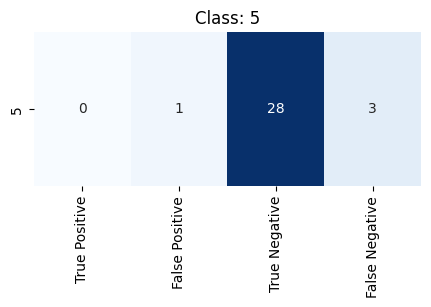

In [27]:
def plot_class_specific_matrices(model, dataloader, class_names):

    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Kreiranje matrice konfuzije
    cm = confusion_matrix(all_labels, all_preds)
    
    # Proverimo da li broj klasa odgovara dimenzijama matrice
    num_classes = cm.shape[0]
    if len(class_names) != num_classes:
        print(f"Warning: Number of class names ({len(class_names)}) does not match number of classes in the confusion matrix ({num_classes}).")
        class_names = class_names[:num_classes]

    # Iteracija kroz sve klase da bismo prikazali pojedinačne matrice sa TP, FP, TN, FN vrednostima
    for i in range(num_classes):
        class_name = class_names[i]
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        
        # Kreiranje DataFrame-a za trenutnu klasu
        data = {'': ['True Positive', 'False Positive', 'True Negative', 'False Negative'],
                'Values': [TP, FP, TN, FN]}
        df = pd.DataFrame(data)

        # Plotovanje matrice za trenutnu klasu
        plt.figure(figsize=(5, 2))
        sns.heatmap(df[['Values']].T, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=df[''].values, yticklabels=[class_name])
        plt.title(f'Class: {class_name}')
        plt.show()

# Primer korišćenja:
class_names = train_subset_df['genre'].unique().tolist()  # Pretpostavljamo da 'genre' sadrži imena klasa
plot_class_specific_matrices(vgg16_model, test_loader, class_names)


/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Epoch 1/15
Epoch 1/15, Loss: 2.0064
Validation Accuracy: 57.58%
Starting Epoch 2/15
Epoch 2/15, Loss: 1.2286
Validation Accuracy: 57.58%
Starting Epoch 3/15
Epoch 3/15, Loss: 0.8604
Validation Accuracy: 63.64%
Starting Epoch 4/15
Epoch 4/15, Loss: 0.5934
Validation Accuracy: 66.67%
Starting Epoch 5/15
Epoch 5/15, Loss: 0.3989
Validation Accuracy: 69.70%
Starting Epoch 6/15
Epoch 6/15, Loss: 0.2623
Validation Accuracy: 72.73%
Starting Epoch 7/15
Epoch 7/15, Loss: 0.1826
Validation Accuracy: 72.73%
Starting Epoch 8/15
Epoch 8/15, Loss: 0.1570
Validation Accuracy: 69.70%
Starting Epoch 9/15
Epoch 9/15, Loss: 0.1649
Validation Accuracy: 72.73%
Starting Epoch 10/15
Epoch 10/15, Loss: 0.1425
Validation Accuracy: 72.73%
Starting Epoch 11/15
Epoch 11/15, Loss: 0.1330
Validation Accuracy: 72.73%
Starting Epoch 12/15
Epoch 12/15, Loss: 0.1072
Validation Accuracy: 66.67%
Starting Epoch 13/15
Epoch 13/15, Loss: 0.1144
Validation Accuracy: 66.67%
Starting Epoch 14/15
Epoch 14/15, Loss: 0.1

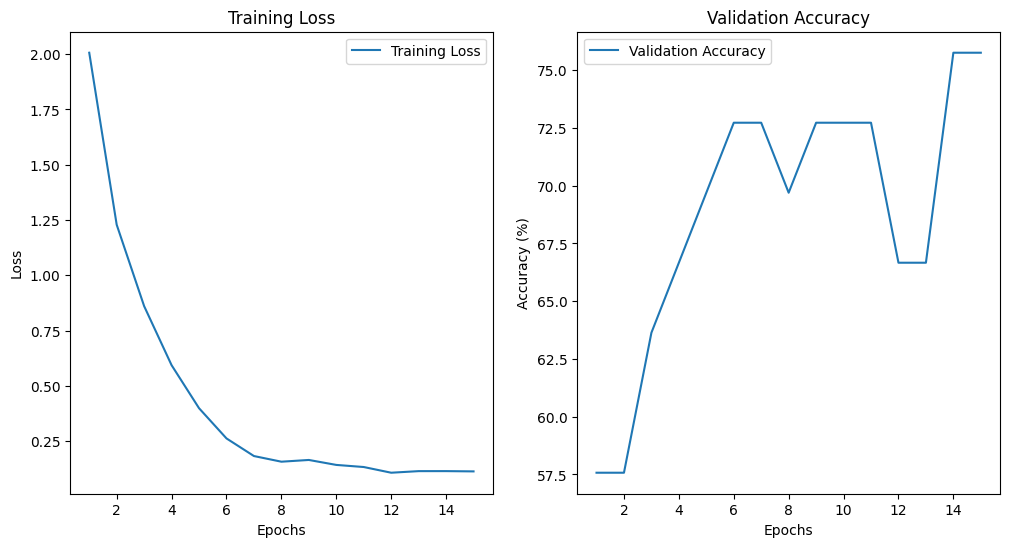

Test Accuracy: 81.25%


In [30]:
alexModel=create_alexnet_model(num_classes).to(device)
train_losses1, valid_accuracies1 = train_model(alexModel, train_loader, valid_loader, num_epochs=15)
plot_results(train_losses1, valid_accuracies1)
evaluate_model(alexModel, test_loader)

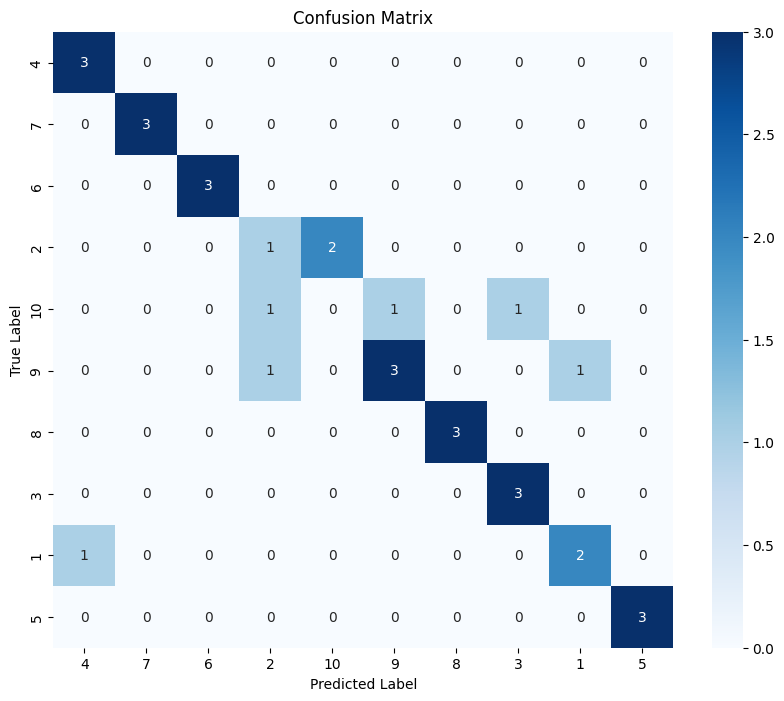

In [31]:
plot_confusion_matrix(alexModel, test_loader, class_names)

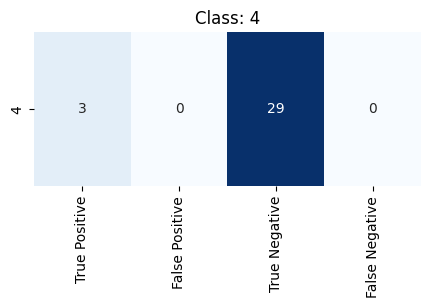

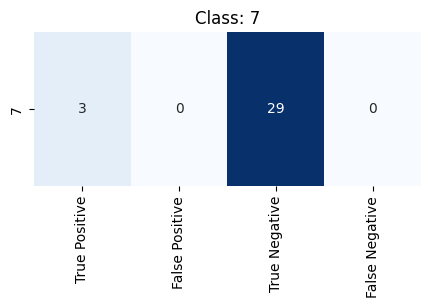

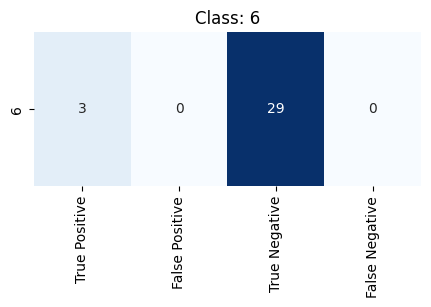

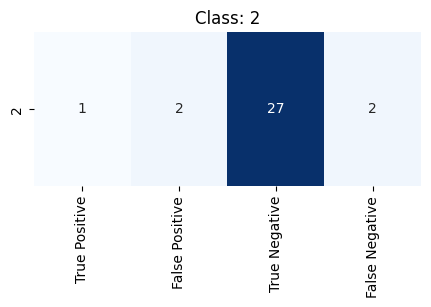

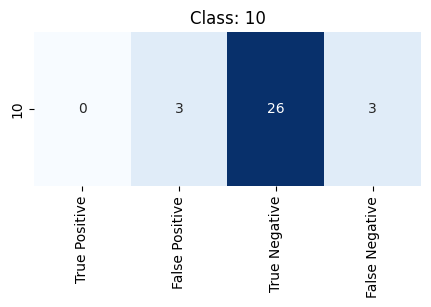

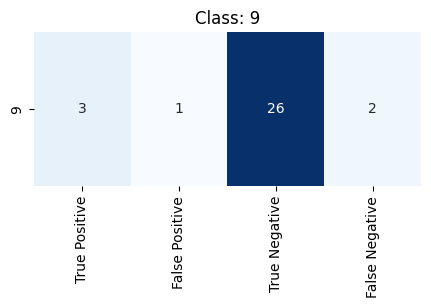

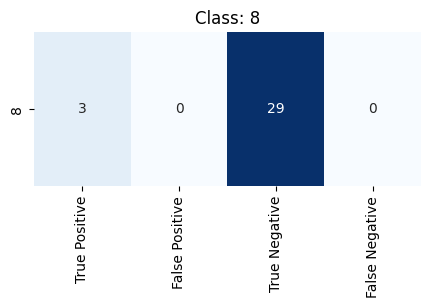

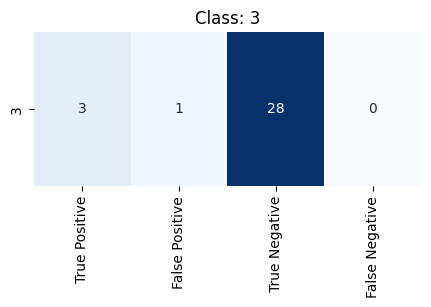

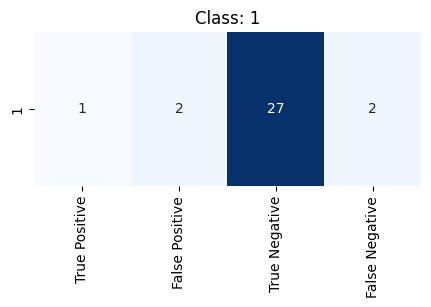

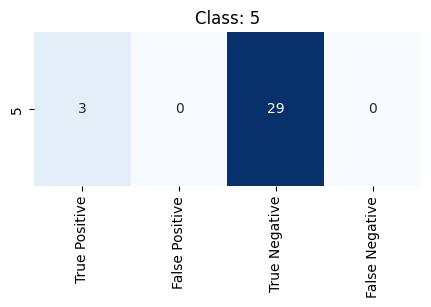

In [32]:
plot_class_specific_matrices(alexModel, test_loader, class_names)


In [28]:
#Treci model koji koristimo je customCNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes=num_classes+1):
        super(CustomCNN, self).__init__()
        
        # Prvi konvolucioni sloj
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Drugi konvolucioni sloj
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Sekvenca konvolucionih slojeva
        self.convs = nn.Sequential(self.layer1, self.layer2)
        
        # Izračunavanje ulazne veličine za prvi potpuno povezani sloj
        self._to_linear = self.get_conv_output_size()
        
        # Potpuno povezani slojevi
        self.fc1 = nn.Linear(301056, 1024)  # Prilagođeno na osnovu izlaznog tenzora
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, num_classes)
        
        # Dropout sloj za regularizaciju
        self.dropout = nn.Dropout(p=0.5)

    def get_conv_output_size(self):
        # Koristimo dummy input da izračunamo izlaznu veličinu iz konvolucionih slojeva
        x = torch.zeros(1, 3, 224, 224)  # Pretpostavlja se ulazna slika dimenzija 224x224x3
        x = self.convs(x)
        print("Conv Output Size:", x.shape)  # Proverava izlaznu veličinu
        return int(x.view(x.size(0), -1).size(1))

    def forward(self, x):
        # Prolazak kroz konvolucione slojeve
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flattenovanje
        
        # Prolazak kroz potpuno povezane slojeve
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [29]:
# Inicijalizacija modela i premeštanje na uređaj
model = CustomCNN(num_classes=num_classes+1).to(device)

# Treniranje modela
num_epochs = 15
train_losses, valid_accuracies = train_model(model, train_loader, valid_loader, num_epochs=num_epochs)


Conv Output Size: torch.Size([1, 96, 56, 56])
Starting Epoch 1/15
Epoch 1/15, Loss: 5.6670
Validation Accuracy: 30.30%
Starting Epoch 2/15
Epoch 2/15, Loss: 4.1239
Validation Accuracy: 15.15%
Starting Epoch 3/15
Epoch 3/15, Loss: 3.8664
Validation Accuracy: 21.21%
Starting Epoch 4/15
Epoch 4/15, Loss: 4.6088
Validation Accuracy: 12.12%
Starting Epoch 5/15
Epoch 5/15, Loss: 3.7106
Validation Accuracy: 24.24%
Starting Epoch 6/15
Epoch 6/15, Loss: 3.0344
Validation Accuracy: 24.24%
Starting Epoch 7/15
Epoch 7/15, Loss: 2.5679
Validation Accuracy: 30.30%
Starting Epoch 8/15
Epoch 8/15, Loss: 2.2376
Validation Accuracy: 18.18%
Starting Epoch 9/15
Epoch 9/15, Loss: 2.1662
Validation Accuracy: 27.27%
Starting Epoch 10/15
Epoch 10/15, Loss: 1.9179
Validation Accuracy: 18.18%
Starting Epoch 11/15
Epoch 11/15, Loss: 1.7999
Validation Accuracy: 33.33%
Starting Epoch 12/15
Epoch 12/15, Loss: 1.8397
Validation Accuracy: 24.24%
Starting Epoch 13/15
Epoch 13/15, Loss: 1.8385
Validation Accuracy: 21.2

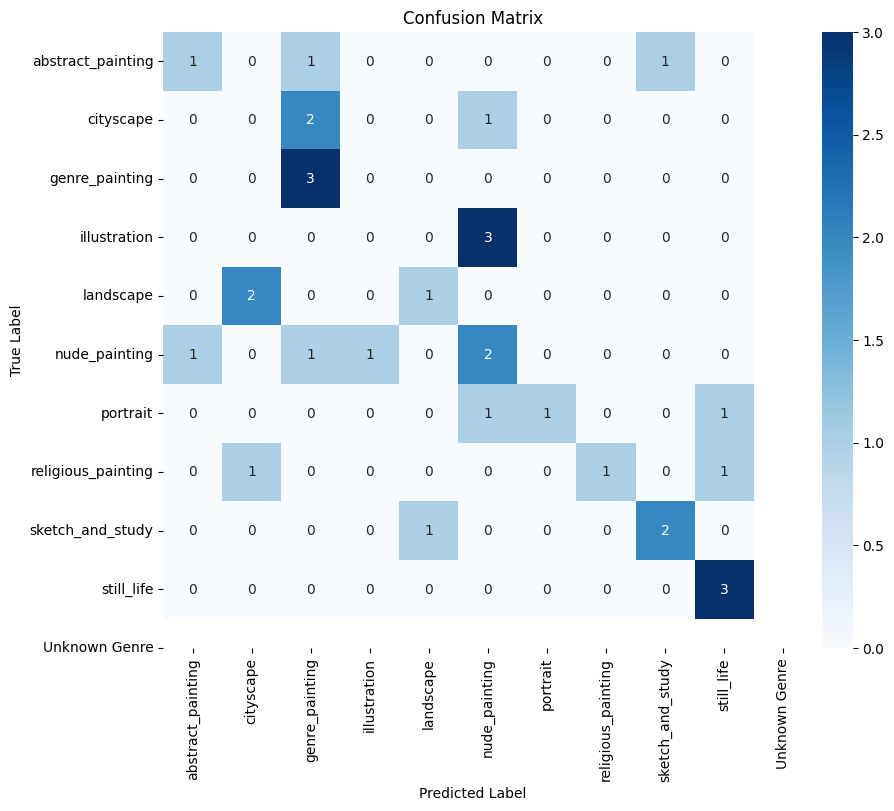

In [30]:
# Plotovanje matrice konfuzije
plot_confusion_matrix(model, test_loader, class_map.values())

In [ ]:
'''Na početku treniranja, model pokazuje visoke vrednosti gubitka i nisku tačnost validacije.
Ovo je očekivano jer model još nije naučio značajne obrasce iz podataka.
U prvih nekoliko epoha, gubitak se postepeno smanjuje, ali tačnost validacije ima oscilacije.
To može ukazivati na to da model još uvek nije stabilizovao svoje učenje ili da su podaci možda složeni za trenutnu arhitekturu modela.

Od epohe 6 do 8, vidimo značajan napredak u tačnosti validacije, koja raste sa 42.42% na 48.48%. 
Ovo je dobar znak da model počinje da uči korisne obrasce.
U narednim epohama, tačnost se ponovo smanjuje, ali još uvek ostaje između 39.39% i 48.48%.
To može ukazivati na problem sa prekomernim učenjem ili možda potrebu za dodatnim podešavanjem hiperparametara.

Na kraju epoha, gubitak se stabilizuje oko 1.90, dok tačnost varira između 39.39% i 48.48%. 
Ova fluktuacija u tačnosti može ukazivati na to da model nije u potpunosti konvergirao ili da su potrebne dodatne 
epohe za stabilizaciju performansi.
'''

In [ ]:
"Cuvanje modela"

model_filename = 'models/vgg16_model.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(vgg16_model, pickle_file)

model_filename = 'models/alexModel.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(alexModel, pickle_file)

model_filename = 'models/model.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(model, pickle_file)